<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os, sys

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
tr_mcc_codes = pd.read_csv(filepath_or_buffer="/content/data/tr_mcc_codes.csv", sep = ';')
tr_types = pd.read_csv(filepath_or_buffer="/content/data/tr_types.csv", sep=';')
transactions = pd.read_csv(filepath_or_buffer="/content/transactions.csv", sep=",", nrows=1000000)
customers_gender_train = pd.read_csv(filepath_or_buffer="/content/data/gender_train.csv", sep=",")

In [ ]:
df = pd.merge(transactions, customers_gender_train, how = "left")
df = pd.merge(df, tr_mcc_codes, how="inner")
df = pd.merge(df, tr_types, how="inner")
tr_day = df.tr_datetime.str.split(n = 1, expand = True)
df["tr_day"] = tr_day[0].astype(int)
# df["tr_time"] = tr_day[1]
df = df.drop(["tr_datetime", "mcc_description", "tr_description", "term_id"], axis=1)
df = df[df.gender.notnull()]
df.head()

,customer_id,mcc_code,tr_type,amount,gender,tr_day
0,39026145,4814,1030,-2245.92,1.0,0
1,39026145,4814,1030,-5614.79,1.0,6
2,39026145,4814,1030,-1122.96,1.0,8
3,39026145,4814,1030,-2245.92,1.0,11
4,39026145,4814,1030,-2245.92,1.0,11


In [ ]:
df_copy = df[df.amount<0].groupby("tr_day").amount.sum()
df_copy.index = df_copy.index.astype(int)
df_copy.sort_index()
# df.copy.plot(figsize=(10, 5))

tr_day
0     -66440564.28
1     -36318167.99
2     -57511150.68
3     -69148579.78
4     -77088269.80
          ...     
452   -85771613.52
453   -71216809.80
454   -53757244.73
455   -81760922.17
456   -64930480.51
Name: amount, Length: 457, dtype: float64

In [ ]:
features = df.loc[:, df.columns != 'gender'].values[:, 1:]
labels = df.loc[:, 'gender'].values

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1, 1))
X = scaler.fit_transform(features)
Y = labels

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [ ]:
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
Y_hat = [round(yhat) for yhat in model.predict(X_test)]
print(accuracy_score(Y_test, Y_hat)) # Test set accuracy
Y_hat = [round(yhat) for yhat in model.predict(X)]
print(accuracy_score(Y, Y_hat)) # Full set accuracy

0.6195607714021684
0.6212342897518023


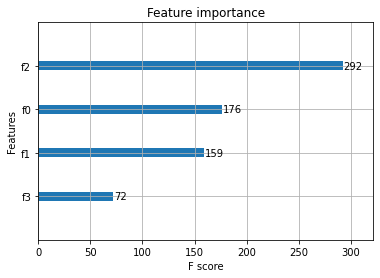

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model)
pyplot.show()

In [ ]:
pd.DataFrame(model.feature_importances_, index=X_train.columns, 
             columns=['Importance'].sort_values(by='Importance'), ascending=False)[:10]

AttributeError: ignored


# Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
logit = LogisticRegression(C=1, solver='lbfgs', max_iter=500, random_state=7, n_jobs=4, multi_class="multinomial")
logit_pipe = Pipeline([('scaler', StandardScaler()), ('logit', logit)])

In [ ]:
logit_pipe.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='multinomial', n_jobs=4,
                                    penalty='l2', random_state=7,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
logit_val_pred = logit_pipe.predict(X_test)
accuracy_score(Y_test, logit_val_pred)

0.5726030025905297

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
first_forest = RandomForestClassifier(n_estimators=100, random_state=7, 
                                       n_jobs=4)

In [ ]:
first_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [ ]:
forest_val_pred = first_forest.predict(X_test)
accuracy_score(Y_test, forest_val_pred)

0.6229441142458932

In [ ]:
pd.DataFrame(first_forest.feature_importances_, index=X_train.columns, 
             columns=['Importance'].sort_values(by='Importance'), ascending=False)[:10]

AttributeError: ignored

# LGBM Classifier

In [ ]:
lgb_clf = LGBMClassifier(random_state=17)

In [ ]:
lgb_clf.fit(X_train, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
accuracy_score(Y_test, lgb_clf.predict(X_test))

0.6336597165061683

# Hyper-Param Tuning

https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm

In [ ]:
param_grid = {'num_leaves': [7, 15, 31, 63, 127, 255], 
              'max_depth': [3, 4, 5, 6, 7, 8, -1]}

In [ ]:
grid_searcher = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, 
                             cv=5, verbose=1, n_jobs=4)

In [ ]:
grid_searcher.fit(X_train, Y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:  7.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=17, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, -1],
                         'num_leaves'

In [ ]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': -1, 'num_leaves': 255}, 0.6405459854971951)

In [ ]:
accuracy_score(Y_test, grid_searcher.predict(X_test))

0.6407546369471138